In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
tfs=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

In [3]:
trainset = torchvision.datasets.GTSRB(
    root='./root', split='train',  transform=tfs,download=True)
testset = torchvision.datasets.GTSRB(
    root='./root', split='test',  transform=tfs,download=True)

100%|██████████| 187490228/187490228 [00:05<00:00, 32348991.58it/s]


Extracting root/gtsrb/GTSRB-Training_fixed.zip to root/gtsrb


100%|██████████| 88978620/88978620 [00:03<00:00, 25099496.33it/s]


Extracting root/gtsrb/GTSRB_Final_Test_Images.zip to root/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 298346.22it/s]


Extracting root/gtsrb/GTSRB_Final_Test_GT.zip to root/gtsrb


In [4]:
print(len(trainset))
print(len(testset))

26640
12630


In [5]:
#Hyper-parameters
epoch_count=20
batch_size=32


# for training:
learning_rate = 0.001
momentum = 0.9

In [6]:
torch.manual_seed(143)
tst_size = 5000
val_size = len(testset) - tst_size
val_data, tst_data = torch.utils.data.random_split(testset, [val_size, tst_size])

ids=torch.randperm(len(testset))

split=tst_size
val_ids,test_ids=ids[split:],ids[:split]

test_sampler=SubsetRandomSampler(test_ids)
val_sampler=SubsetRandomSampler(val_ids)


#Dataloaders
test_loader = DataLoader(testset, batch_size, pin_memory=True,sampler=test_sampler)
val_loader = DataLoader(testset, batch_size,pin_memory=True,sampler=val_sampler)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,pin_memory=True)

In [7]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

torch.Size([3, 104, 274])


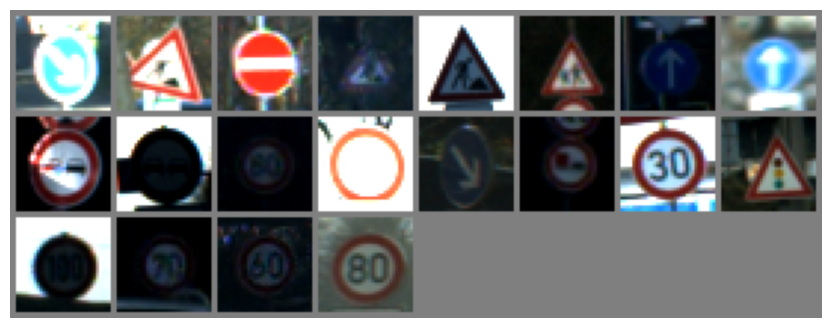

tensor([38, 25, 17, 25, 25, 28, 35, 35,  9,  9,  5, 15, 38, 10,  1, 26,  7,  4,
         3,  5])


In [8]:
printsampler=DataLoader(testset,20,sampler=test_sampler)

def grid_plot(img):
    img=img/2 + .5
    print(img.shape)
    plt.figure(figsize=(15,4))
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
    #plt.savefig(f'grid.png')
    plt.show()

dataiter=iter(printsampler)
images,labels=next(dataiter)

grid_plot(torchvision.utils.make_grid(images))
print(labels)

In [9]:
class ImgClassifier(nn.Module):
  def __init__(self):
      super(ImgClassifier, self).__init__()
      self.conv1 = nn.Conv2d(3,32,3)
      self.conv2 = nn.Conv2d(32,64,3)

      self.pool1 = nn.MaxPool2d(2)
      self.dout1 = nn.Dropout(0.5)
      self.conv3 = nn.Conv2d(64,512,3)
      self.conv4 = nn.Conv2d(512,512,3)

      self.pool2 = nn.MaxPool2d(2)
      self.dout2 = nn.Dropout(0.5)
      self.fc=nn.Linear(512*5*5,1024)
      self.out=nn.Linear(1024,43)

  def forward(self, x):

      x= self.conv1(x)
      x=F.elu(x)

      x= self.conv2(x)
      x=F.elu(x)

      x=self.pool1(x)
      x=self.dout1(x)

      x= self.conv3(x)
      x=F.elu(x)

      x= self.conv4(x)
      x=F.elu(x)

      x=self.pool2(x)
      x=self.dout2(x)
      #flatten all dimension except batch size
      x=torch.flatten(x,1)

      x = self.fc(x)
      x=F.elu(x)
      x=self.out(x)
      output=F.log_softmax(x,dim=1)

      return output

model=ImgClassifier()
model = model.to(device)  # put all model params on GPU.

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
print(model)

ImgClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=12800, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=43, bias=True)
)


In [11]:
foo1=[]#train_loss
foo2=[]#train_accuracy
foo3=[]#valid_loss
foo4=[]#valid_accuracy
bestmodel={'epoch':  0,
        'model_state_dict': model.state_dict(),
        'loss':   0,
        'accuracy':  0
        }

In [12]:
for epoch in range(1,epoch_count+1):
    running_loss=0.0
    running_total = 0
    running_correct = 0
    run_step = 0

    for i, (images, labels) in enumerate(train_loader):
        model.train()

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()  # reset gradients.
        loss.backward()  # compute gradients.
        optimizer.step()  # update parameters.

        running_loss += loss.item()
        running_total += labels.size(0)

        with torch.no_grad():
            _, predicted = outputs.max(1)
        running_correct += (predicted == labels).sum().item()
        run_step += 1
        if i %  500== 0:
            # check accuracy.
            print(f'epoch: {epoch}, steps: {i}, '
                  f'train_loss: {running_loss / run_step :.3f}, '
                  f'running_acc: {100 * running_correct / running_total:.1f} %')
            foo1.append(running_loss/run_step)
            foo2.append(100 * running_correct / running_total)
            running_loss = 0.0
            running_total = 0
            running_correct = 0
            run_step = 0

    # validation
    best_val_acc=[0,0]
    correct = 0
    val_loss=0
    total = 0
    counter=0
    model.eval()

    with torch.no_grad():
        for data in val_loader:
            counter+=1
            images,labels=data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += loss_fn(outputs,labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total

    if 100 * correct / total >= bestmodel['accuracy']:
      bestmodel={'epoch':  epoch,
        'model_state_dict': model.state_dict(),
        'loss':   val_loss,
        'accuracy':   val_acc
        }
    print(f'Validation accuracy: {100 * correct / total: .3f}%   ,'
              f'Validation loss:{val_loss/counter:.3f}')
    foo3.append(val_loss/counter)
    foo4.append(100 * correct / total)

print('Finished Training')

epoch: 1, steps: 0, train_loss: 3.745, running_acc: 0.0 %
epoch: 1, steps: 500, train_loss: 2.698, running_acc: 28.2 %
Validation accuracy:  68.100%   ,Validation loss:1.065
epoch: 2, steps: 0, train_loss: 1.179, running_acc: 62.5 %
epoch: 2, steps: 500, train_loss: 0.527, running_acc: 84.9 %
Validation accuracy:  87.431%   ,Validation loss:0.521
epoch: 3, steps: 0, train_loss: 0.571, running_acc: 90.6 %
epoch: 3, steps: 500, train_loss: 0.187, running_acc: 94.8 %
Validation accuracy:  90.944%   ,Validation loss:0.422
epoch: 4, steps: 0, train_loss: 0.150, running_acc: 90.6 %
epoch: 4, steps: 500, train_loss: 0.111, running_acc: 97.2 %
Validation accuracy:  90.668%   ,Validation loss:0.422
epoch: 5, steps: 0, train_loss: 0.163, running_acc: 96.9 %
epoch: 5, steps: 500, train_loss: 0.072, running_acc: 98.0 %
Validation accuracy:  91.809%   ,Validation loss:0.381
epoch: 6, steps: 0, train_loss: 0.113, running_acc: 93.8 %
epoch: 6, steps: 500, train_loss: 0.056, running_acc: 98.6 %
Valida

In [13]:
lastmodel={'epoch':  epoch_count,
        'model_state_dict': model.state_dict(),
        'loss':   val_loss,
        'accuracy':   val_acc
        }
#torch.save(lastmodel,'lastmodel.pth')
#torch.save(bestmodel,'bestmodel.pth')

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    model.eval() # Set model in eval mode. Don’t forget!
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs=model(images)
        _, predicted = outputs.max(dim=1)
        # predicted.shape: (B)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Test accuracy: {test_acc} %')
    print(f'Test error rate: {100 - 100 * correct / total: .2f} %')

Test accuracy: 93.14 %
Test error rate:  6.86 %


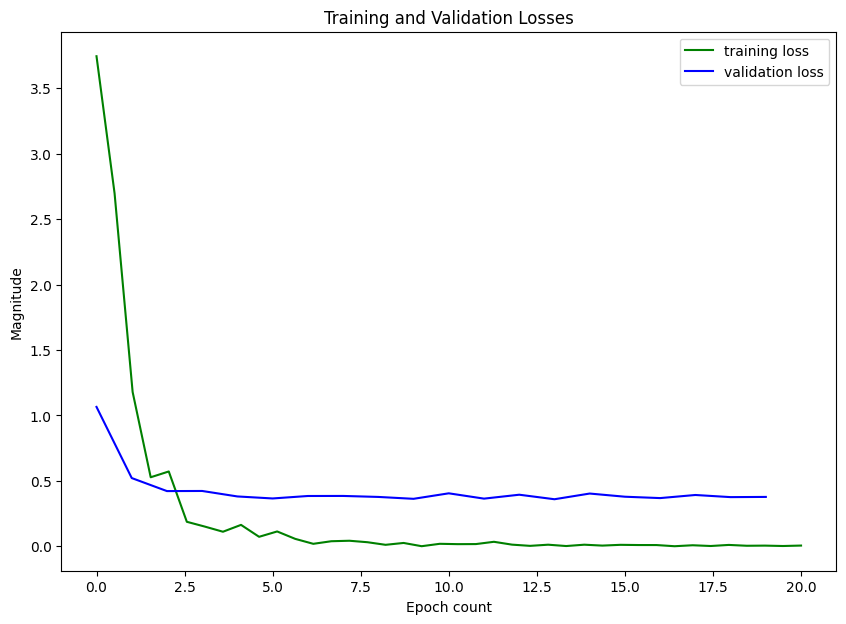

In [15]:

x=np.linspace(0,20,40)
x1=np.arange(0,20)

plt.figure(figsize=(10,7))
plt.plot(
    x,foo1,'g-',label='training loss'
)
plt.plot(
    x1,foo3,'b-',label='validation loss'
)
plt.xlabel("Epoch count")
plt.ylabel("Magnitude")
plt.title("Training and Validation Losses")
plt.legend()
plt.savefig('val_train_loss.png',dpi=300)
plt.show()

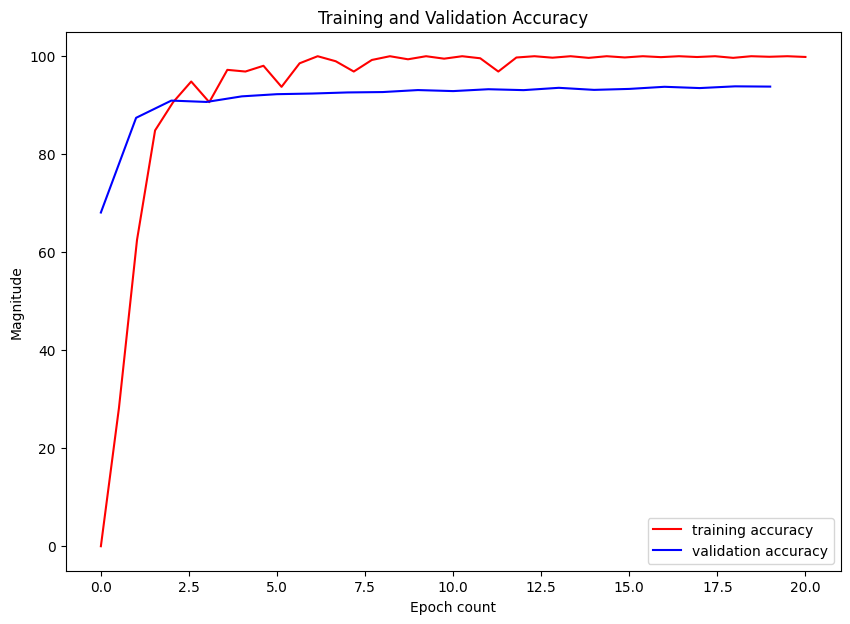

In [16]:
plt.figure(figsize=(10,7))
plt.plot(
    x,foo2,'r-',label='training accuracy'
)
plt.plot(
    x1,foo4,'b-',label='validation accuracy'
)
plt.xlabel("Epoch count")
plt.ylabel("Magnitude")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('val_train_acccuracy.png',dpi=300)
plt.show()